# Predicting Subscriber Churn for a Video Streaming Platform

![Woman working on multiple screens](marketinganalytics.jpg)

## Summary

**Streamvid** is a popular video streaming platform specialized in educational content, where creators publish online video tutorials and lessons about any topic.

Their next goal is to leverage AI-driven solutions to analyze and make predictions about their subscribers and improve their marketing strategy around attracting new subscribers and retaining current ones.

> **Disclaimer:** This is mock data generated for a fictional company. The data was generated using Le Chat's generative AI model.

## Objectives
<b><i> Segmentation </b></i><br>
Streamvid wants to establish more personalized and targeted campaigns to reduce subscriber churn. To do so, they need to identify usage patterns to build subscriber personas for future marketing plans. These subscriber personas can then be used to automate targeted marketing campaigns, determine chatbot trajectories and uncover hidden target markets.

<b><i> Prediction </b></i><br>
Additionally, they want to be able to anticipate when a customer may be getting close to churning based on their characteristics and site activity. This requires building a model to predict churn status based on their site usage. Such a model can then be used to trigger targeted marketing campaigns for at-risk subscribers.

## Key Questions
-  What subscriber segments can be identified in the data to create more targeted marketing campaigns?
-  What are the warning signs of subscribers who may churn?

## Data Overview
The `AZWatch_subscribers.csv` **dataset** contains information about subscribers and their status over the last year:

|Column name|Description|
|-----------|-----------|
|`subscriber_id`|The unique identifier of each subscriber user|
|`age_group`|The subscriber's age group|
|`engagement_time`|Average time (in minutes) spent by the subscriber per session|
|`engagement_frequency`|Average weekly number of times the subscriber logged in the platform (sessions) over a year period|
|`subscription_status`|Whether the user remained subscribed to the platform by the end of the year period (subscribed), or unsubscribed and terminated her/his services (churned)|



## Methodology
- **Exploration:** Visualize and disaggregate data to identify overarching trends
- **Customer segementation**: Identify clusters of subscriber personas for targeted marketing
- **Preprocessing for ML models:** One-hot encoding of categorical features, standardization of numerical features
- **ML Models:** Logistic Regression, Random Forest, Decision Trees
- **Model Evaluation:** Accuracy, confusion matrices, feature importance


## Key Findings

## Notebook Structure

## How to use this notebook

# Imports

In [1]:
## Base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings("ignore")
## Machine learning utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
## Model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
## Model evaluation
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

## Set environment random state
r_state = 42

## Specify the file path of your CSV file
file_path = "data/AZWatch_subscribers.csv"

## Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df.head()


,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status
0,14451,18-34,5.55,7,subscribed
1,18386,under 18,5.12,12,subscribed
2,12305,35 and over,4.25,4,churned
3,17546,18-34,8.54,15,subscribed
4,15399,18-34,12.12,20,subscribed


# Explore data

## Disaggregate by subscription status

### Overall churn and subscribe rate

(0.0, 100.0)

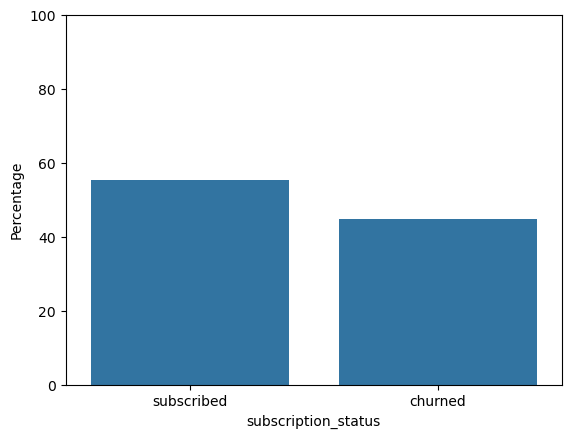

In [2]:
sns.barplot(data=df['subscription_status'].value_counts(normalize=True)*100)
plt.ylabel('Percentage')
plt.ylim(0,100)

### Distribution of engagement frequency between subscribed and churned customers

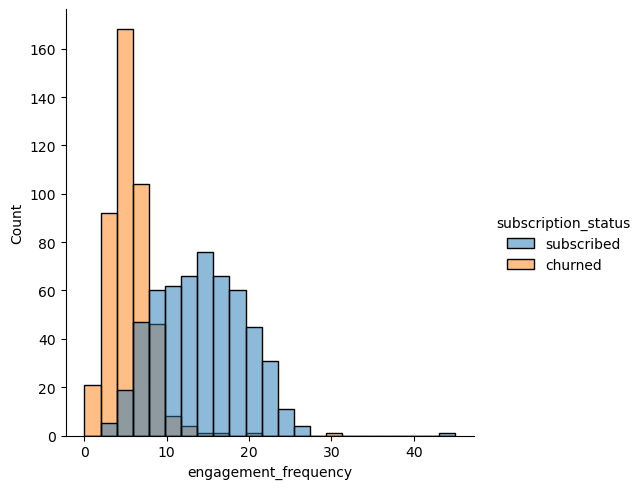

In [3]:
## Set palette to use throughout
# custom_palette = {
#     'subscribed': '#bcbddc',
#     'churned': '#a8c8c8'
# }

sns.displot(data=df, x='engagement_frequency', hue='subscription_status')

### Distribution of engagement time between subscribed and churned customers

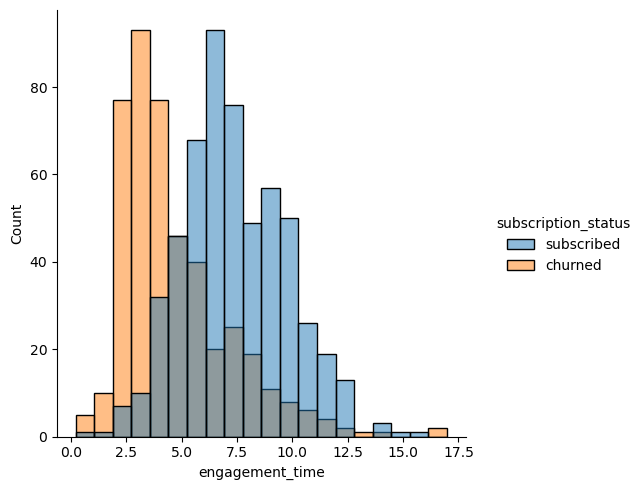

In [4]:
sns.displot(data=df, x='engagement_time', hue='subscription_status')

### Relationship between engagement frequency and time overall

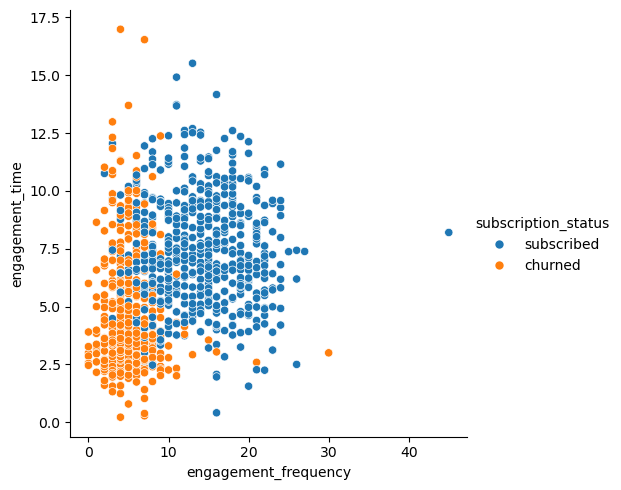

In [5]:
sns.relplot(data=df, x='engagement_frequency', y='engagement_time', hue='subscription_status')

## Disaggregate by age group and subscription status

In [6]:
percentage_df = (
    df
    .groupby(['age_group', 'subscription_status'])
    .size()
    .rename('count')
    .reset_index()
    .pipe(
        lambda d: d.assign(
            percentage=100 * d['count'] / d.groupby('age_group')['count'].transform('sum')
        )
    )
    .drop(columns='count')
)

percentage_df['percentage'] = percentage_df['percentage'].round(2)



percentage_df

,age_group,subscription_status,percentage
0,18-34,churned,28.22
1,18-34,subscribed,71.78
2,35 and over,churned,58.09
3,35 and over,subscribed,41.91
4,under 18,churned,47.14
5,under 18,subscribed,52.86


In [7]:
## Define standard age group order
age_group_order = ['under 18', '18-34', '35 and over']

### Percentage of churn vs. subscribed by age group

<Axes: xlabel='age_group', ylabel='percentage'>

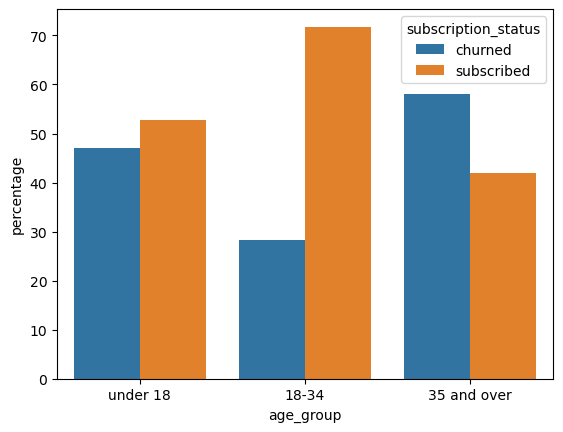

In [8]:
## Plot proportion of subscribed vs. churned by age group
sns.barplot(
    data=percentage_df,
    x='age_group',
    y='percentage',
    hue='subscription_status',
    order=age_group_order
)

### Distribution of engagement frequency: by age group & churn status

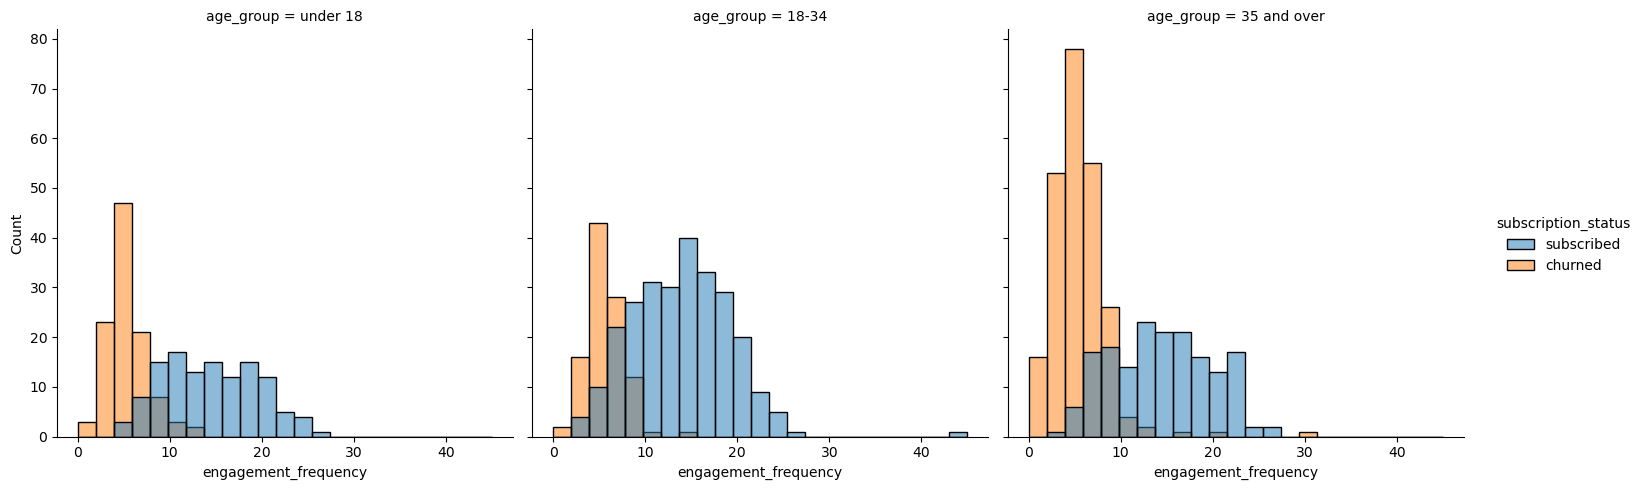

In [9]:
## Plot the distribution of engagement frequency
## Disaggregated by churn status and age group
sns.displot(data=df, x='engagement_frequency', hue='subscription_status', col='age_group', 
            col_order=age_group_order)

### Distribution of engagement time: by age group & churn status

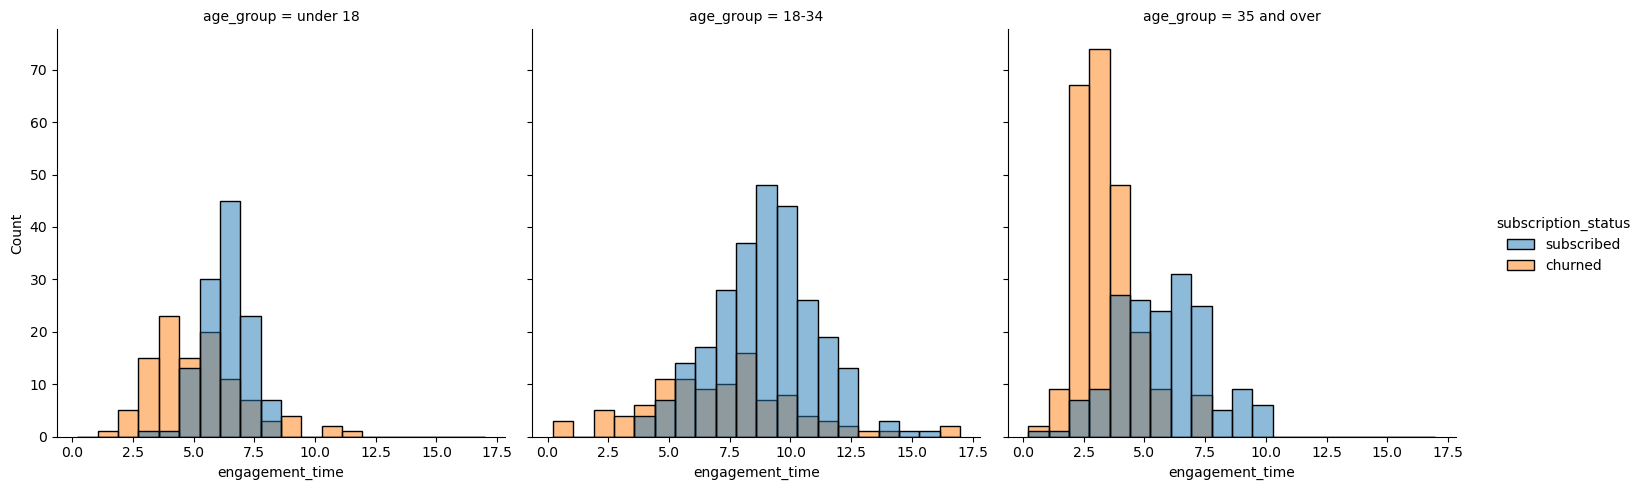

In [10]:
## Plot the distribution of engagement time
## Disaggregated by churn status and age group
sns.displot(data=df, x='engagement_time', hue='subscription_status', col='age_group', 
            col_order=age_group_order)

### Relationship between engagement frequency and time: by age group & churn status

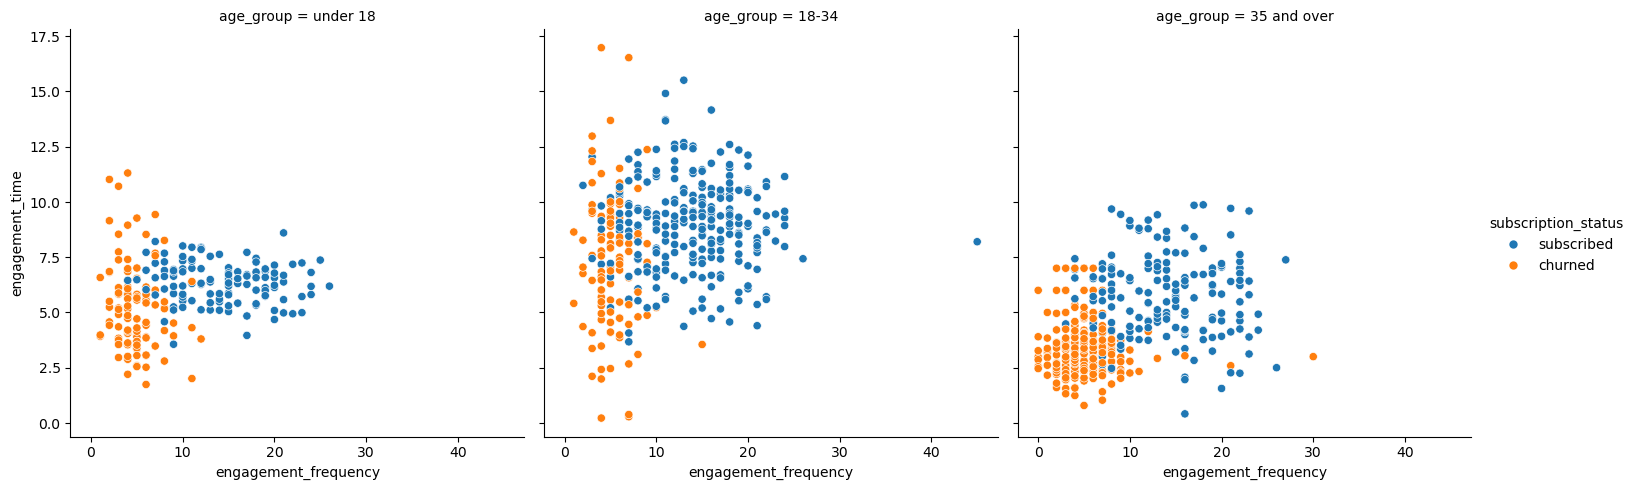

In [11]:
## Plot relationship between engagement frequency and time
## Disaggregated by churn status and age group
sns.relplot(data=df, x='engagement_frequency', y='engagement_time', hue='subscription_status', col='age_group', col_order=age_group_order)

# Customer Segmentation

In [12]:
## Set up a K-means cluster model pipeline

X_numeric = df.drop(['subscriber_id','subscription_status', 'age_group'], axis=1)  

## K Means preprocessing
    ## - Standardize numeric columns to same scaler
    ## - Run model with 3 clusters initially
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(init='random', n_init=20, random_state=42))
    ])

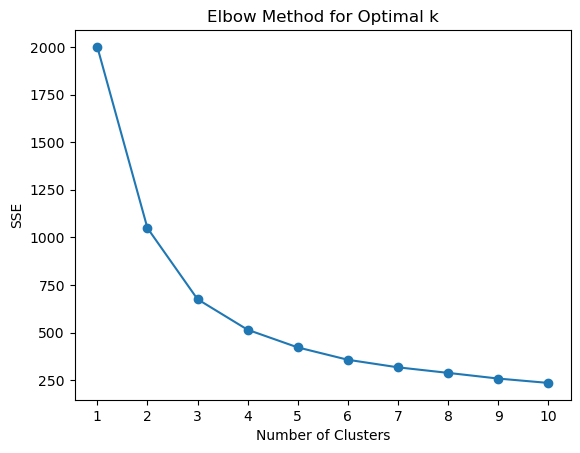

In [13]:
## Find the optimal number of clusters to segment

sse = []

# Record the SSE for each value of k
for k in range(1, 11):
    # Update the number of clusters in the pipeline
    pipeline.set_params(kmeans__n_clusters=k)

    # Fit the pipeline
    pipeline.fit(X_numeric)

    # Append the inertia (SSE) to the list
    sse.append(pipeline.named_steps['kmeans'].inertia_)

# Visualize results
plt.plot(range(1, 11), sse, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()

## Look for the point in the curve where SSE begins to rapidly decrease (in this case, at 3 clusters)

In [14]:
#----
#  Run K means with optimal cluster number
#-----

pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=3, init='random', n_init=20, random_state=42))
    ])

pipeline.fit(X_numeric)

# Get cluster labels
clusters = pipeline.predict(X_numeric)

In [15]:
## Inspect cluster labels
clusters[0:10]

array([0, 0, 0, 2, 2, 1, 2, 2, 1, 0], dtype=int32)

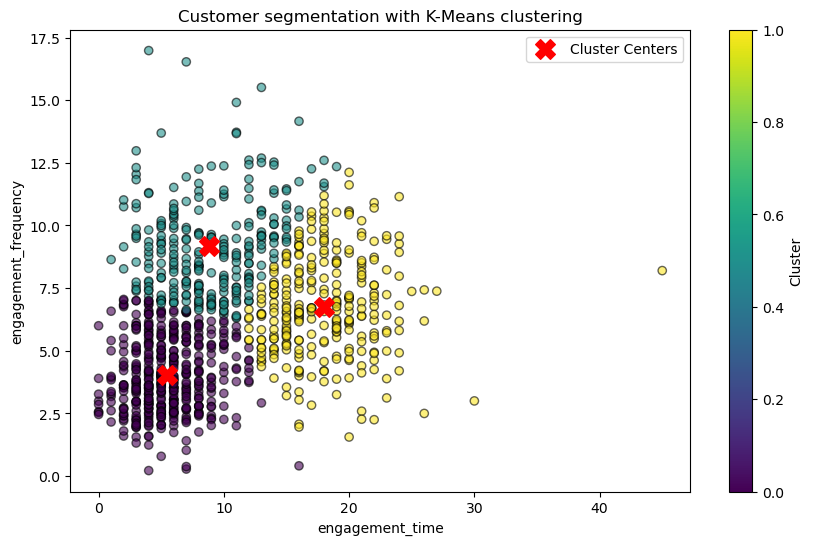

In [16]:
# ---------------
# Visualize clusters
# ---------------

## Get the scaled data from the pipeline
X_scaled = pipeline.named_steps['scaler'].transform(X_numeric)

## Get cluster centers in the scaled space
cluster_centers_scaled = pipeline.named_steps['kmeans'].cluster_centers_

## Inverse transform the cluster centers to the original scale
cluster_centers = pipeline.named_steps['scaler'].inverse_transform(cluster_centers_scaled)

## Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    X_numeric.iloc[:, 1],  # First numerical feature (e.g., engagement_time)
    X_numeric.iloc[:, 0],  # Second numerical feature (e.g., engagement_frequency)
    c=clusters,
    cmap='viridis',
    alpha=0.6,
    edgecolors='k'
)

## Add cluster centers in the original scale
plt.scatter(
    cluster_centers[:, 1],
    cluster_centers[:, 0],
    c='red',
    marker='X',
    s=200,
    label='Cluster Centers'
)

## Add labels and title
plt.xlabel(X_numeric.columns[0])
plt.ylabel(X_numeric.columns[1])
plt.title('Customer segmentation with K-Means clustering')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

## Clusters

By visualizing the results of the K-means clustering algorithm via the relationship between enagement frequency and engagement time and color coding by cluster number and churn status, we see that 3 main subscriber segments emerge. Additionally, by looking at the table showing percentages of subscribed and churned customers per cluster, we see how the cluster patterns of engagement frequency and time affect the likelihood to churn.

**Cluster 2: High Engagement Frequency (Yellow)**
* This cluster shows a broad range of engagement time, yet consistently high engagement frequency (above ~10).
* This cluster has the lowest churn rate, with **98% of customers remaining subscribed**.

**Cluster 1: Low Engagement Frequency, High Engagement Time (Blue)**
* This cluster shows lower engagement frequency, yet consistently high engagement time (above ~7.5 minutes).
* This cluster still has a relatively low churn rate, with **71% of customers remaining subscribed**.

**Cluster 0: Low Engagement Frequency & Time (Purple)**
* This cluster shows both low engagement frequency and low engagement time, with frequency values consistently below 10 and time values below 7.5.
* This cluster has the highest churn rate by far, with **82% of subscribers churning** and only **18% remaining subscribed**.

We can see that a similar pattern generally holds when looking at the clusters per age group in the plot further down. However, we do see that as we move towards older age groups, less customers fall into Cluster 1 and more become divided between Clusters 2 and 0. 

**This reinforces the patterns that we saw in the exploratory analysis:**

- Churn risk increases in older age groups, with those over 34 representing the highest risk.
- Engagement time becomes a more decisive factor for churn likelihood in older age groups, as the amount of churned customers stops abruptly after roughly 7.5 minutes of engagement.

## Conclusions

**Key thresholds for retaining subscribers:**
  * Engagement time > 7.5 minutes
  * Engagement frequency > 10

**Targeted marketing campaigns in the form of email reminders or app notifications could be triggered once subscribers fall below these thresholds. These could be increased slightly to protect from churn in more sensitive older age groups.**


In [17]:
## Add cluster labels to data for aggregation

df_clusters = df.copy()
df_clusters['cluster'] = clusters

df_clusters.head()

,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status,cluster
0,14451,18-34,5.55,7,subscribed,0
1,18386,under 18,5.12,12,subscribed,0
2,12305,35 and over,4.25,4,churned,0
3,17546,18-34,8.54,15,subscribed,2
4,15399,18-34,12.12,20,subscribed,2


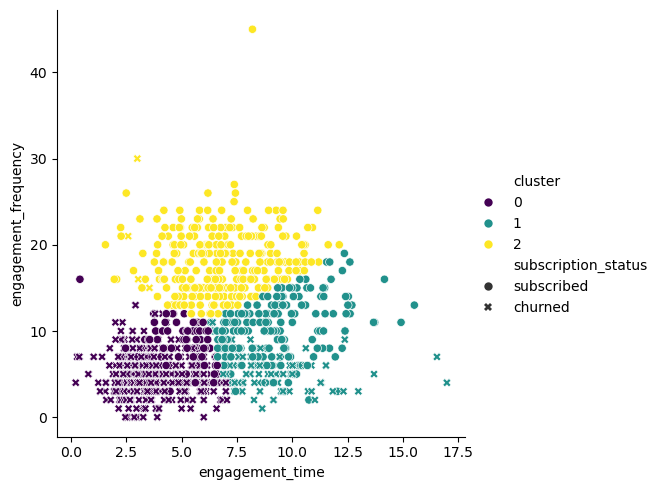

In [18]:
## Visualize cluster results and subscribed and churned customers within each

sns.relplot(data=df_clusters, x='engagement_time', y='engagement_frequency',
            hue='cluster', style='subscription_status', palette='viridis')

In [19]:
## Calculate percentage of customers churned and subscribed per cluster

clusters_churned = (
    df_clusters
    .groupby(['cluster', 'subscription_status'])
    .size()
    .rename('count')
    .reset_index()
    .assign(
        percentage=lambda d: 100
        * d['count']
        / d.groupby('cluster')['count'].transform('sum')
    )
    .drop(columns='count')
    .round({'percentage': 0})
)

clusters_churned

,cluster,subscription_status,percentage
0,0,churned,82.0
1,0,subscribed,18.0
2,1,churned,29.0
3,1,subscribed,71.0
4,2,churned,2.0
5,2,subscribed,98.0


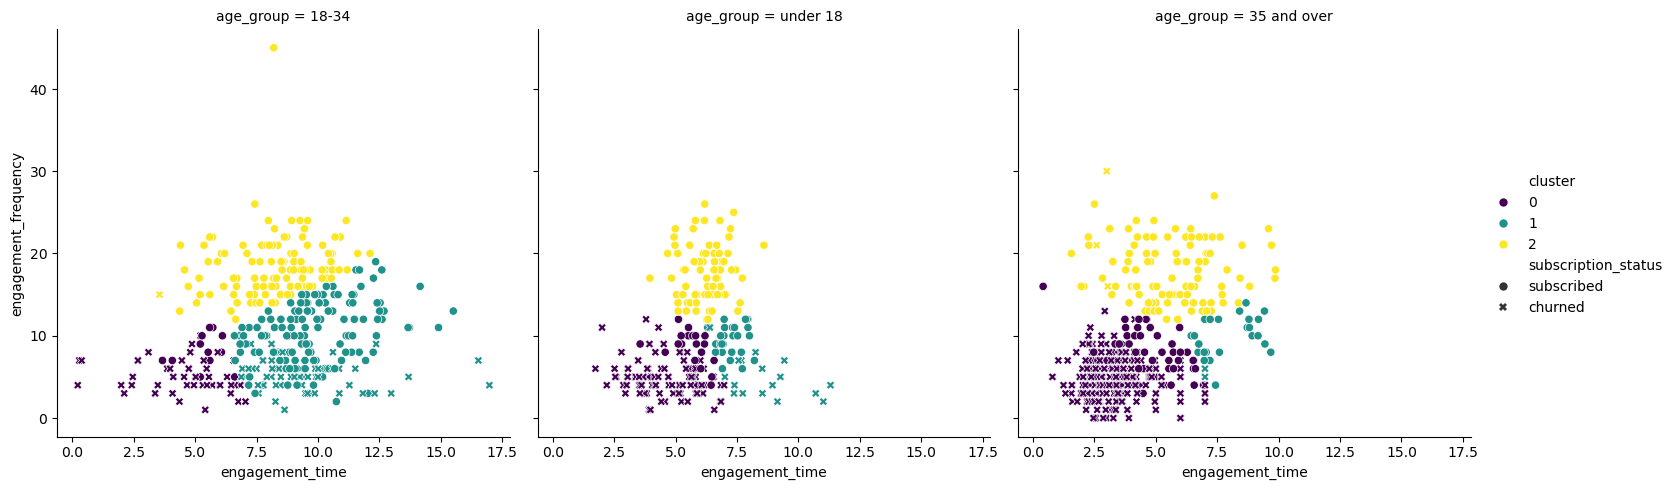

In [20]:
## Visualize clusters alongside churn status

sns.relplot(data=df_clusters, x='engagement_time', y='engagement_frequency',
            hue='cluster', style='subscription_status', col='age_group', palette='viridis')

In [21]:
## Calculate percentage of customers churned and subscribed within each cluster and age group

clusters_grouped = (
    df_clusters
    .groupby(['cluster', 'age_group', 'subscription_status'])
    .size()
    .rename('count')
    .reset_index()
    .assign(
        percentage=lambda d: 100
        * d['count']
        / d.groupby('cluster')['count'].transform('sum')
    )
    .drop(columns='count')
    .round({'percentage': 0})
)

clusters_grouped

,cluster,age_group,subscription_status,percentage
0,0,18-34,churned,11.0
1,0,18-34,subscribed,3.0
2,0,35 and over,churned,52.0
3,0,35 and over,subscribed,10.0
4,0,under 18,churned,20.0
5,0,under 18,subscribed,5.0
6,1,18-34,churned,21.0
7,1,18-34,subscribed,52.0
8,1,35 and over,churned,2.0
9,1,35 and over,subscribed,9.0


# Machine learning model building

## Split the data
Here we split the data into:
- the target variable (the customer's churned or subscribed status, indicated by y)
- the features we will use to predict the target (columns like engagement frequency, engagement time and age group, indicated by X)

Both the target and the feature are split into a train and a test set.

The train set is used to configure our model. The test set is set aside and only used to test the model once it's built.

In [22]:
## Separate predictor variables from class label
X = df_clusters.drop(['subscriber_id','subscription_status'], axis=1)

## Using map here instead of LabelEncoder to be able to customize labels for each value
y = df_clusters["subscription_status"].map({"churned": 0, "subscribed": 1})

## Split into training and test sets  
X_train, X_test, y_train, y_test = train_test_split(
                        ## Use 80/20 training/test split, fixed random state for reproducibility
                        X, y, test_size=.2, random_state=42)

X.head()

,age_group,engagement_time,engagement_frequency,cluster
0,18-34,5.55,7,0
1,under 18,5.12,12,0
2,35 and over,4.25,4,0
3,18-34,8.54,15,2
4,18-34,12.12,20,2


## Preprocessing
It's important to always split the data BEFORE executing preprocessing steps.

This avoids "data leakage": when characteristics of the test and training data mix during preprocessing, allowing the model to 'see' the test data beforehand and artificially inflating the accuracy of the model on the test data.

<b>Preprocessing steps:</b>
- Change the categorical feature "age group" to numeric data - a series of 0's and 1's that the model can interpret
- Standardized the numeric data to have the same range and distribution

Some models work best with standardized data (such as Logistic Regression), while others don't need it and can even work better when the numeric data is left in it's natural ranges, even if they are different (liked Random Forest).

We will create two different versions of the preprocessing pipeline, one standardizing the numeric data and one without, and test how the different preprocessing steps influence the models' accuracies.

In [23]:
## Define which columns are categorical vs numeric
categorical = ["age_group"]  
numeric = ["engagement_time", "engagement_frequency"]  

## Preprocessing version 1
    ## - One hot encode categorical columns
    ## - Standardize numeric columns to same scale
preprocess1 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric),
    ],
    remainder="drop"  
)

## Preprocessing version 2
    ## - One hot encode categorical columns
    ## - Pass through numeric columns untransformed
preprocess2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ],
    remainder="drop"  
)

preprocessors = {
    "preprocessing1": preprocess1,  # e.g., one-hot + standard scaling
    "preprocessing2": preprocess2   # e.g., one-hot + minmax scaling
}

## Fit models
In this section:
 1) model choices are explained
 2) each model is fit using each of the 2 preprocessing version (2 x 3 combinations)
 3) The overall accuracy for each model x preprocessing combination is calculated

### Selected models
Logistic regression, decision tree and Random Forest classifiers were chosen for their simplicity, adaptability and interpretability. The advantages and disadvantages of each are listed below.

In [24]:
## Apply each preprocessing version to each model in pipelines
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]

pipelines = []

## Iterate over each combination of preprocessing version and model (2x3 combinations)
for (preprocessor_name, preprocessor), model in product(preprocessors.items(), models):
    ## Set up pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipelines.append(pipeline)
    
    ## Fit each pipeline to training data
    pipeline.fit(X_train, y_train)
    
    ## Score each pipeline on test set
    score = pipeline.score(X_test, y_test)
    
    ## Print each preprocessor + model combo accuracy score
    print(f"{preprocessor_name} + {type(model).__name__}: {score:.4f}")

preprocessing1 + LogisticRegression: 0.9250
preprocessing1 + DecisionTreeClassifier: 0.8750
preprocessing1 + RandomForestClassifier: 0.8750
preprocessing2 + LogisticRegression: 0.9250
preprocessing2 + DecisionTreeClassifier: 0.8750
preprocessing2 + RandomForestClassifier: 0.8950


## Evaluate models
In this section:
1) each of the fitted models is evaluated for accuracy, precision, recall and f1 score
2) A confusion matrix is displayed showing the false and true positive and negative rates

### Evaluation metrics
- explain the different evaluation metrics

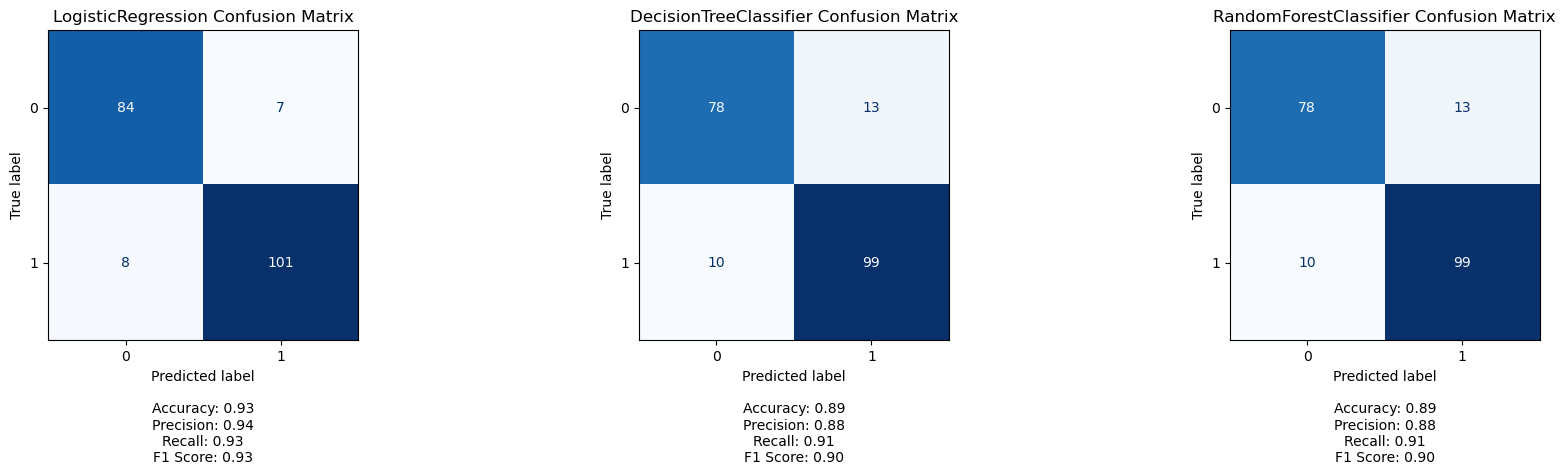

In [25]:
# Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through the models and plot the confusion matrices
for i, model in enumerate(models):
    ## Fit the model 
    pipe = Pipeline([
        ('preprocessor', preprocess2),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)

    ## Get predictions
    y_pred = pipe.predict(X_test)

    ## Get the model name
    model_name = type(pipe.named_steps['model']).__name__

    ## Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=axes[i],
        cmap='Blues',
        colorbar=False
    )

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision =precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')       
    f1 = f1_score(y_test, y_pred, average='binary')              

    # Add metrics as text below the confusion matrix
    metrics_text = (
        f"Accuracy: {accuracy:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"F1 Score: {f1:.2f}"
    )
    axes[i].text(
        0.5, -0.2, metrics_text,
        ha='center', va='top',
        transform=axes[i].transAxes,
        fontsize=10
    )

    # Add the model name as the title
    axes[i].set_title(f"{model_name} Confusion Matrix")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Tune Models

In [26]:
## Set up param grids per model

param_grid_lr = {
    'model__C': [0.1, 1, 10],  # Regularization strength
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

param_grid_dt = {
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

In [27]:
## Store param girds for each model
grids = [param_grid_lr, param_grid_dt, param_grid_rf]

bestparams_dict = {}

## Iterate over each model and its param grid
for m, g in zip(models, grids):
    ## Set up pipeline using best preprocdessing version
    pipeline = Pipeline([
        ('preprocessor', preprocess1),
        ('model', m)
    ])
    ## Initiate grid search cross validation with model pipeline + 5 cv splits, selecting best params by            highest accuracy
    grid_search = GridSearchCV(pipeline, g, cv=5, scoring='f1', n_jobs=-1)
    
    ## Fit to training data
    grid_search.fit(X_train, y_train)
    
    ## Display best params per model
    print(f"{type(pipeline['model']).__name__} best params: {grid_search.best_params_}")
    
    ## Store best params per model
    bestparams_dict[type(pipeline['model']).__name__] = grid_search.best_params_

LogisticRegression best params: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
DecisionTreeClassifier best params: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_split': 10}
RandomForestClassifier best params: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 100}


In [28]:
bestparams_dict.items()

dict_items([('LogisticRegression', {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}), ('DecisionTreeClassifier', {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_split': 10}), ('RandomForestClassifier', {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 100})])

### Re-evaluate models

In [29]:
## Re-run models with best params

## Map model names to their class
model_classes = {
    'LogisticRegression': LogisticRegression,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier 
}

# pipelines = {}

for model_name in bestparams_dict.keys():
    
    ## Create a default model
    model = model_classes[model_name]()

    ## Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    ## Set the best parameters using set_params
    pipeline.set_params(**bestparams_dict[model_name])

    ## Fit the pipeline
    pipeline.fit(X_train, y_train)

    ## Sore on test set
    new_score = pipeline.score(X_test, y_test)

    ## Display new accuracies with best params
    print(f"{type(model).__name__} new accuracy: {new_score:.4f}")


LogisticRegression new accuracy: 0.9250
DecisionTreeClassifier new accuracy: 0.8900
RandomForestClassifier new accuracy: 0.9300


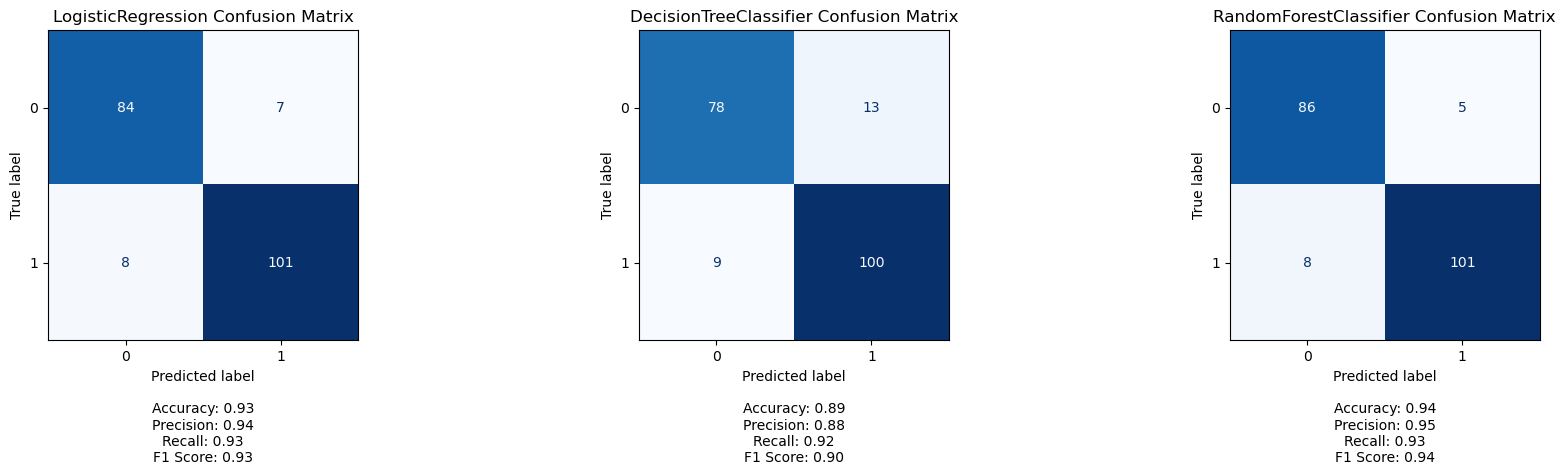

In [30]:
## Plot confusion matrices and accuracy metrics for each tuned model

## Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

## Loop through the models and plot the confusion matrices
for i, model in enumerate(models):
    model_name = type(model).__name__
    
    ## Fit the model 
    pipe = Pipeline([
        ('preprocessor', preprocess1),
        ('model', model)
    ])

    pipe.set_params(**bestparams_dict[model_name])
    
    pipe.fit(X_train, y_train)

    ## Get predictions
    y_pred = pipe.predict(X_test)

    ## Get the model name
    model_name = type(pipe.named_steps['model']).__name__

    ## Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=axes[i],
        cmap='Blues',
        colorbar=False    
    )

     # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision =precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')       
    f1 = f1_score(y_test, y_pred, average='binary')              

    # Add metrics as text below the confusion matrix
    metrics_text = (
        f"Accuracy: {accuracy:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"F1 Score: {f1:.2f}"
    )
    axes[i].text(
        0.5, -0.2, metrics_text,
        ha='center', va='top',
        transform=axes[i].transAxes,
        fontsize=10
    )
    
    ## Add the model name as the title
    axes[i].set_title(f"{model_name} Confusion Matrix")

## Adjust layout and show the plot
plt.tight_layout()
plt.show()


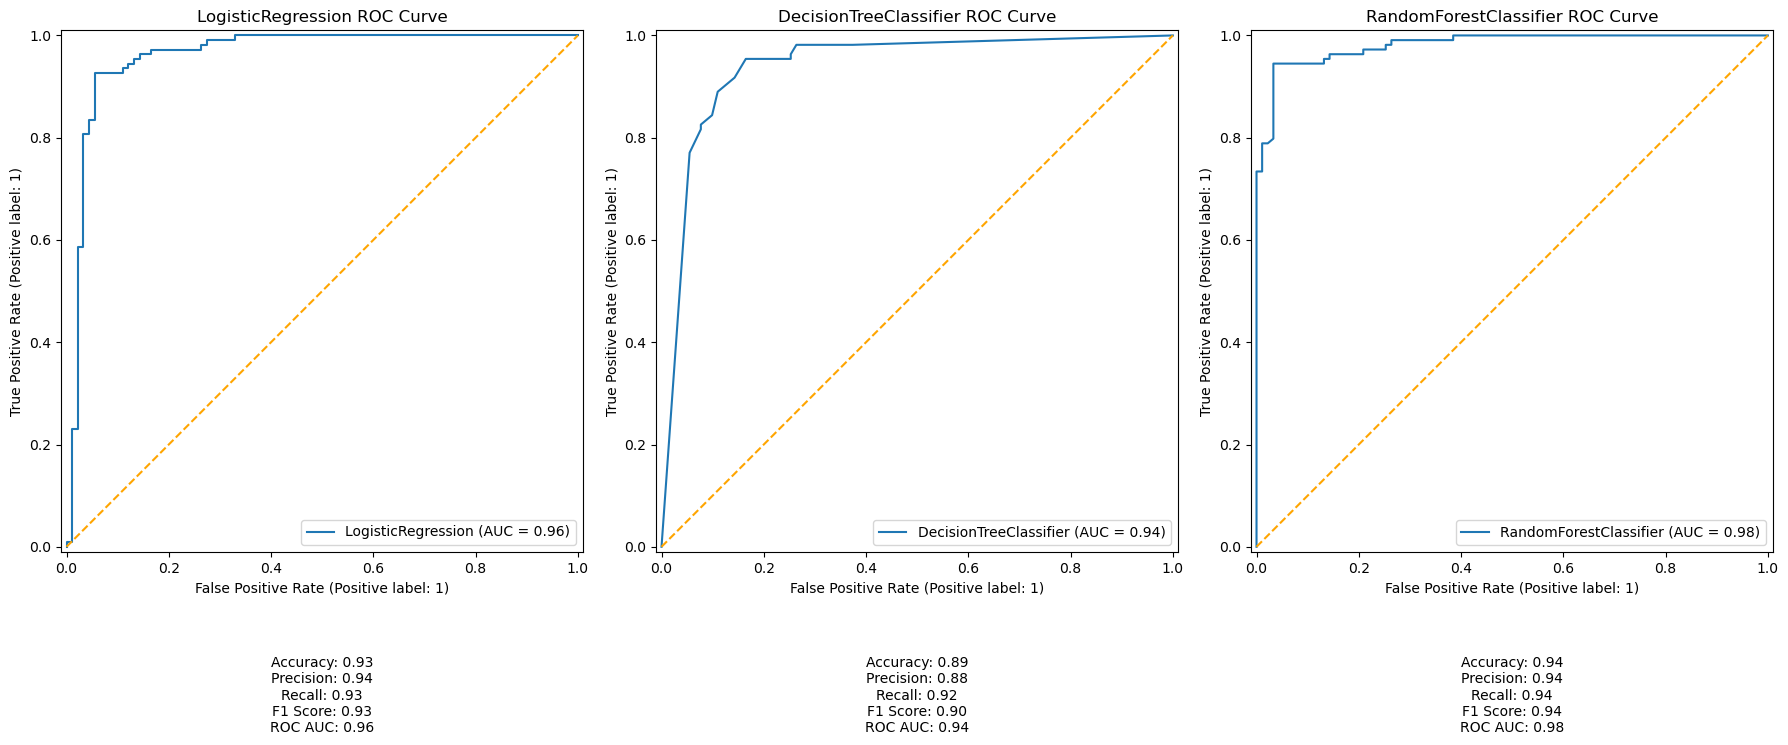

In [31]:
## Plot Receiver Operating Curve (ROC) for each tuned model

# Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Loop through the models and plot the ROC curves
for i, model in enumerate(models):
    model_name = type(model).__name__

    ## Fit the model
    pipe = Pipeline([
        ('preprocessor', preprocess1),
        ('model', model)
    ])

    if model_name in bestparams_dict:
        pipe.set_params(**bestparams_dict[model_name])

    pipe.fit(X_train, y_train)

    ## Get predicted probabilities for ROC curve
    y_proba = pipe.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    ## Plot the ROC curve
    RocCurveDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        ax=axes[i],
        name=model_name
    )

    # Calculate metrics
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba)

    # Add metrics as text below the ROC curve
    metrics_text = (
        f"Accuracy: {accuracy:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"F1 Score: {f1:.2f}\n"
        f"ROC AUC: {roc_auc:.2f}"
    )
    axes[i].text(
        0.5, -0.2, metrics_text,
        ha='center', va='top',
        transform=axes[i].transAxes,
        fontsize=10
    )

    ## Add the model name as the title
    axes[i].set_title(f"{model_name} ROC Curve")
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='orange')  # Add diagonal line for reference

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Final model selection
- The Random Forest model shows the best performance in terms of F1 score and area under the ROC; therefore, we will move forward using it for interpretation and deployment
- explain choice
- explain trade-off between precision and recall between top 2 models

# Establish churn risk factors based on model: Feature Importance

We can calculate the contribution each feature of the data makes to the model's predictions by using permutation feature importance

This runs the model multiple times, taking each feature out once, and seeing how removing that feature affects the model's performance. Features that result in larger decreases in accuracy when removed are rated as more important

We can see that for our model, engagement frequency contributes the most to the model's prediction of churn status, followed by engagement time. A customer's age group contributes relatively little to the model's prediction of their churn status.

This tells us that engagement frequency is likely to play a greater role in preventing subscriber churn than engagement time. This is a clue that our marketing campaigns should likely be targeted to optimize engagement frequency whenever possible.

([0, 1, 2, 3],
 [Text(0, 0, 'engagement_frequency'),
  Text(1, 0, 'engagement_time'),
  Text(2, 0, 'age_group'),
  Text(3, 0, 'cluster')])

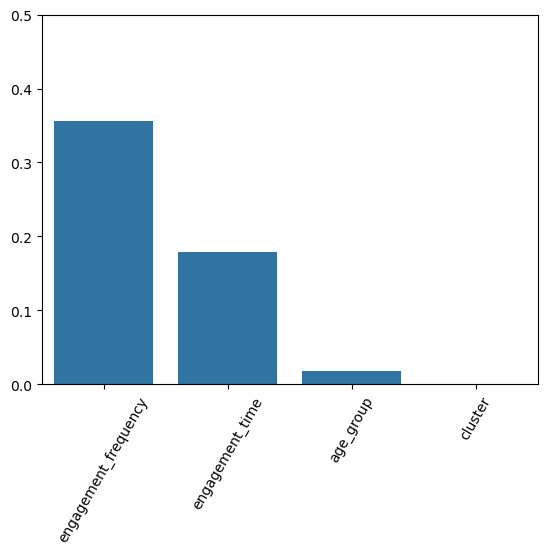

In [32]:
rf_pipe = pipe = Pipeline([
        ('preprocessor', preprocess1),
        ('model', RandomForestClassifier())
    ])

pipe.set_params(**bestparams_dict['RandomForestClassifier'])

rf_model = pipe.fit(X_train, y_train)



perm = permutation_importance(
    rf_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

perm_importance = (
    pd.Series(perm.importances_mean, index=X_test.columns)
    .sort_values(ascending=False)
)

## Plot feature importances
sns.barplot(data=perm_importance)
plt.ylim(0,0.5)
plt.xticks(rotation=60)

# Extract churn probabilities per user

We can extract the probabilities of each class assigned to each user by the model. For each user, the model assigns a probability of being classified as each class. 

In our scenario, we have 2 classes:
- subscriiption_status = 0 (Customer remained subscribed)
- subscription_status = 1 (Customer churned)

We will extract the probabilities of the predcited class being 1 (churned) for each customer.

In [33]:
## Extract probabilities of the negative class (subscription_status = 1, user churned)
churn_probs = rf_model.predict_proba(X_test)[:, 1].round(2)

## Create new dataframe with churn probabilities and actual churn status for each user
churn_results = (
    X_test
    .assign(
        churn_probability=churn_probs,
        actual_churn=y_test.values
    )
)

## Show first 10 rows of probabiliti results
churn_results.sort_values(
    'churn_probability',
    ascending=False
).head(10)


,age_group,engagement_time,engagement_frequency,cluster,churn_probability,actual_churn
867,35 and over,4.90,22,2,1.0,1
527,18-34,11.19,18,2,1.0,1
355,18-34,9.27,24,2,1.0,1
845,18-34,6.56,17,2,1.0,1
914,35 and over,6.45,22,2,1.0,1
668,under 18,6.83,18,2,1.0,1
298,18-34,9.98,15,1,1.0,1
55,18-34,7.64,19,2,1.0,1
554,18-34,9.59,13,1,1.0,1
670,18-34,9.87,15,1,1.0,1


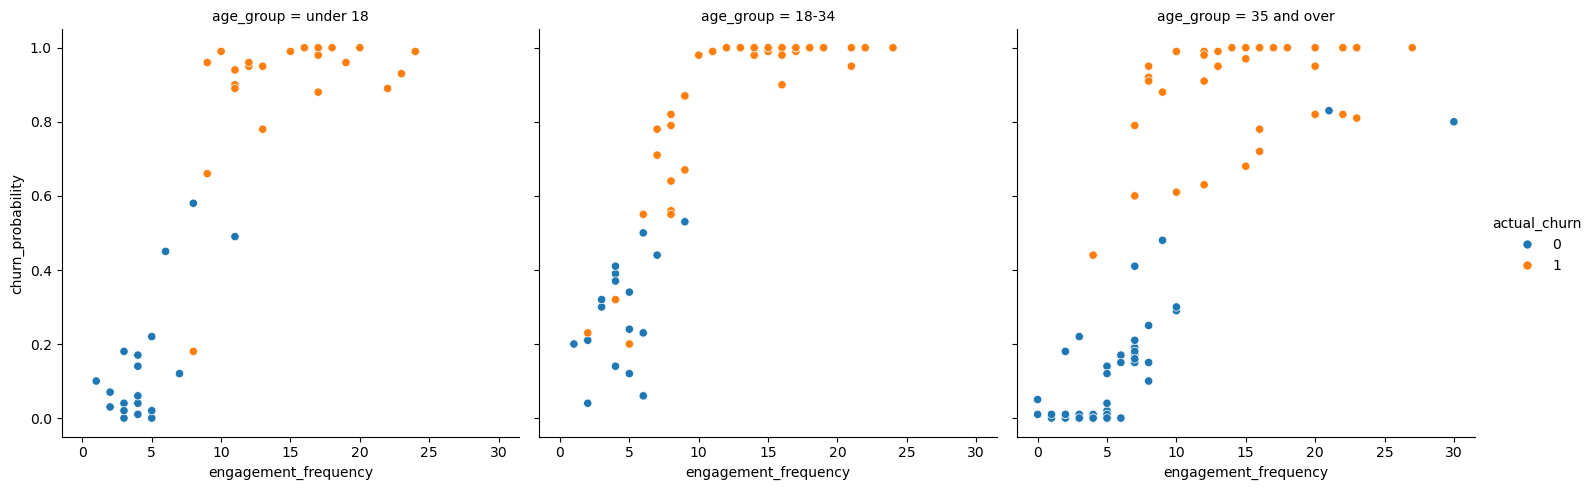

In [34]:
## Plot churn probabilities relative to engagement frequency and actual churn status
sns.relplot(data=churn_results, x='engagement_frequency', y='churn_probability', hue='actual_churn', col='age_group', 
            col_order=age_group_order)

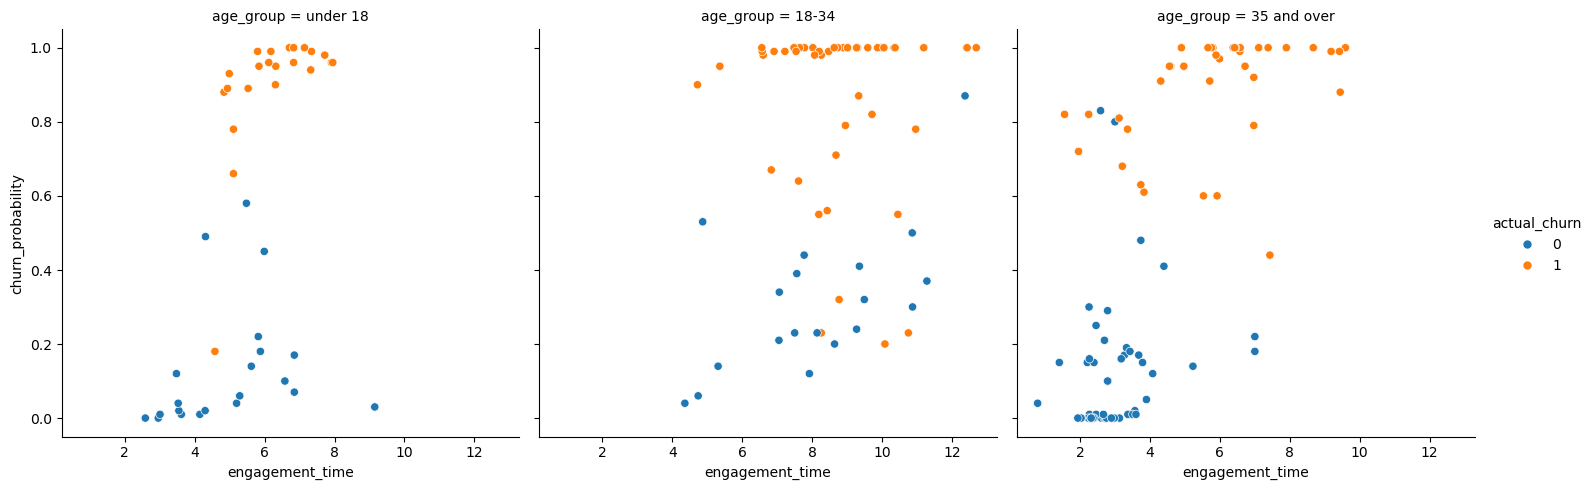

In [35]:
## Plot churn probabilities relative to engagement time and actual churn status
sns.relplot(data=churn_results, x='engagement_time', y='churn_probability', hue='actual_churn', col='age_group',
           col_order=age_group_order)

In [36]:
## Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test,
    churn_probs,
    n_bins=10
)


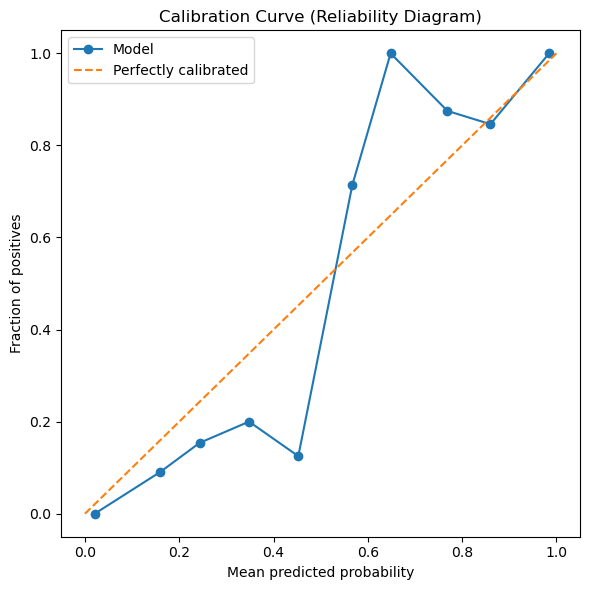

In [37]:
## Plot calibration curve
plt.figure(figsize=(6, 6))

# Calibration curve
plt.plot(
    mean_predicted_value,
    fraction_of_positives,
    marker='o',
    label='Model'
)

# Perfect calibration reference line
plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    label='Perfectly calibrated'
)

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.tight_layout()
plt.show()


# Deploy model to predict churn for new subscribers

We can deploy the model by including it in a Python function that takes in the engagement characteristics and age group of a user and returns their probability of churning.

**This function could be integrated into automated workflow and data pipelines that:**
- Runs the engagement statistics of all users through the model on a daily or aggregated weekly basis
- Returns their probability of churning
- If the churn probability is above a certain percentage, an automated marketing email is triggered with a call to action, subscriber discount or another membership perk to boost engagement

In [38]:
## Deploy the model as a function
## - Takes in a user's engagement characteristic and age group
## - Outputs the probability they will churn

def predict_churn_probability(
    engagement_time: float,
    engagement_frequency: int,
    age_group: str,
    pipeline
) -> str:

    # Allowed age groups
    allowed_age_groups = ['under 18', '18-34', '35 and over']
    
    # Check if the provided age_group is valid
    if age_group not in allowed_age_groups:
        raise ValueError(f"Invalid age_group: {age_group}. Must be one of {allowed_age_groups}.")
        
    user_df = pd.DataFrame(
        [{
            'engagement_time': engagement_time,
            'engagement_frequency': engagement_frequency,
            'age_group': age_group
        }]
    )

    probability = pipeline.predict_proba(user_df)[0, 1]
    return f"Probability the user churns: {probability:.2f}"



In [39]:
## Use function to predict churn probability for a user based on their engagement time, engagement frequency and age group

predict_churn_probability(
    engagement_time=120,
    engagement_frequency=3,
    age_group='18-34',
    pipeline=rf_model
)


'Probability the user churns: 0.20'